The transfer function of the causal LTI system with a realization $(A, B, C, D)$ is given by
\begin{equation*}
    H(s) = C(sI_{n} - A)^{-1}B.
\end{equation*}
Notice that $H(s) = Cv(s)$, where $v(s)$ is the solution of a parametrized linear coercive model
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$. 

We replace the matrix computation of $(sI_{n} - A)^{-1}B$ with a parametrized model (1), and the transfer function $H(s)$ is the output of the model, with $C$ serving as the output operator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pymor.basic import *
from pymor.algorithms.to_matrix import to_matrix
from pymor.vectorarrays.numpy import NumpyVectorSpace
from pymor.operators.numpy import NumpyMatrixOperator
from pymor.operators.constructions import LincombOperator
from pymor.parameters.functionals import ProjectionParameterFunctional

In [2]:
def TF_exact(A,B,C,s):

    # NumPy convertions
    A = A if isinstance(A, np.ndarray) else to_matrix(A).toarray()
    B = B if isinstance(B, np.ndarray) else to_matrix(B)
    C = C if isinstance(C, np.ndarray) else to_matrix(C)
    
    tf = (C@np.linalg.inv(s*np.eye(A.shape[0]) - A)@B)

    return tf

In [3]:
def MatrixModel(A, B, C):

    '''
    Description
    -----------
    This function creates a StationaryModel for the following linear coercive model derived from the given three matrices A, B, and C:
    
        a(v, w; s) = w*(sI_n - A)v and l(w) = w*B.

    Parameters
    ----------
    A: NumpyMatrixOperator or numpy.ndarray
        A.shape = (n, n) or to_matrix(A).shape = (n, n)
    B: NumpyMatrixOperator or numpy.ndarray
        A.shape = (n, 1) or to_matrix(B).shape = (n, 1)
    C: NumpyMatrixOperator or numpy.ndarray
        A.shape = (1, n) or to_matrix(C).shape = (1, n)

    Return
    ------
    model_TF: StationaryModel
    '''

    # Define operators (and also a dimension of a model)
    if isinstance(A, np.ndarray):
        dim = A.shape[0]
        A_op = NumpyMatrixOperator(A)
    else:
        dim = to_matrix(A).shape[0]
        A_op = A

    if isinstance(B, np.ndarray):
        B_op = NumpyMatrixOperator(B) 
    else:
        B_op = B  

    if isinstance(C, np.ndarray):
        C_op = NumpyMatrixOperator(C)  
    else:
        C_op = C

    I_op = NumpyMatrixOperator(np.eye(dim))
    
    # Define parameter functional for 's'
    s_param = ProjectionParameterFunctional('s', 1)

    # Define bilinear form a(v, w; s) = w*(sI - A)v
    a_op_1 = LincombOperator([I_op, A_op], [s_param, -1])

    # Define linear functional l(w) = w^*B
    l_op_1 = B_op

    # Define the StationaryModels
    model_TF = StationaryModel(operator=a_op_1, rhs=l_op_1, output_functional = C_op)

    return model_TF


In [60]:
# StationaryModel constructed using random numpy arrays
matrixA = np.random.rand(20, 20)
matrixB = np.random.rand(20).reshape(20,1)
matrixC = np.random.rand(20).reshape(1,20)

# StationaryModel
model_TF = MatrixModel(A = matrixA, B = matrixB, C = matrixC)
model_TF

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=NumpyMatrixOperator(<1x20 dense>),
    products={},
    output_d_mu_use_adjoint=True)

In [ ]:
# Set a value for evaluation
parameter = 1.4 + 2*1j  # s = 1.4 + 2i

# Solve the model - (sI_n - A)^{-1}B
solution = model_TF.solve(parameter).to_numpy()

# Get the output - C(sI_n - A)^{-1}B
output = model_TF.output(parameter)

# Exact transfer function
exact = TF_exact(matrixA, matrixB, matrixC, parameter)

# A comparison between the model's result and the exact computation
print(f'The output of the model is {output[0,0]}.')
print(f'The exact value of a transfer function H{parameter} is {exact[0,0]}.')
print(f'|H(s) - H_m(s)| is {abs(exact - output)[0,0]}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The output of the model is (-0.31345947757878984-0.1010464452723012j).
The exact value of a transfer function H(1.4+2j) is (-0.31345947757879-0.10104644527230121j).
|H(s) - H_m(s)| is 1.6711069443220836e-16.


In [33]:
# StationaryModel constructed using matrices obtained from penzl example
from pymor.models.examples import penzl_example

penzl = penzl_example()

model_penzl = MatrixModel(penzl.A, penzl.B, penzl.C)
model_penzl

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<1006x1006 dense>), NumpyMatrixOperator(<1006x1006 sparse, 1012 nnz>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<1006x1 dense>),
    output_functional=NumpyMatrixOperator(<1x1006 dense>),
    products={},
    output_d_mu_use_adjoint=True)

In [ ]:
# Set a value for evaluation
parameter = -1 + 7*1j  # s = - 1 + 7i

# Solve the model - (sI_n - A)^{-1}B
solution = model_penzl.solve(parameter).to_numpy()

# Get the output - C(sI_n - A)^{-1}B
output = model_penzl.output(parameter)

# Exact transfer function
exact = TF_exact(penzl.A, penzl.B, penzl.C, parameter)

# A comparison between the model's result and the exact computation
print(f'The output of the model is {output[0,0]}.')
print(f'The exact value of a transfer function H{parameter} is {exact[0,0]}.')
print(f'|H(s) - H_m(s)| is {abs(exact - output)[0,0]}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The output of the model is (4.959665384975282-1.4507365255117162j).
The exact value of a transfer function H(-1+7j) is (4.959665384975283-1.4507365255117162j).
|H(s) - H_m(s)| is 8.881784197001252e-16.


## POD-Galerkin RB method

Let $A \in \mathbb{R}^{n \times n}$, $B \in \mathbb{R}^{n \times 1}$, and $C \in \mathbb{R}^{1 \times n}$, and let $\mathcal{P}$ be the set of admissible parameters for the linear coercive FOM described above. The proposed approach is to approximate the transfer function over the parameter space $\mathcal{P}$ using ROM evaluations instead of exact matrix computations. For model reduction, we employ the POD-Galerkin RB method. It is important to note that this approximation is effective if the parameter space $\mathcal{P}$ is known, as the snapshot matrix $S$, whose column entries are snapshot solutions ($S[:,i] = (s_{i}I - A)^{-1}B$), is constructed based on parameters within the given parameter space $\mathcal{P}$. 

To demonstrate the proposed method, we will use `penzl_example` from `pymor.models.examples`.

In [36]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, penzl.C)

In [37]:
# Define a parameter space - P
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a training set - snapshot parameters
training_set = parameter_space.sample_randomly(50)

# Compute FOM solutions for the parameters in the training set
solution_snapshots = model_penzl.solution_space.empty()
for s in training_set:
    solution_snapshots.append(model_penzl.solve(s))

# Snapshot matrix S - pyMOR framework
print(f'An {solution_snapshots.impl._array.shape[0]} by {solution_snapshots.impl._array.shape[1]} matrix (obtained through pyMOR) is \n {solution_snapshots}')

# Snapshot matrix S
snapshot_matrix = solution_snapshots.to_numpy().T
print(f'An {snapshot_matrix.shape[0]} by {snapshot_matrix.shape[1]} snapshot matrix is \n {snapshot_matrix}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

An 50 by 1006 matrix (obtained through pyMOR) is 
 [[ 0.10791712 -0.09056608  0.05208595 ...  0.00099429  0.0009933
   0.00099232]
 [ 0.10508859 -0.09433111  0.05131127 ...  0.00099761  0.00099662
   0.00099562]
 [ 0.10858926 -0.08958912  0.05227672 ...  0.00099346  0.00099247
   0.00099149]
 ...
 [ 0.1037334  -0.09596436  0.05095332 ...  0.00099911  0.00099811
   0.00099712]
 [ 0.10717139 -0.09161048  0.05187756 ...  0.0009952   0.00099421
   0.00099322]
 [ 0.10234687 -0.0975374   0.05059421 ...  0.00100059  0.00099959
   0.0009986 ]]
An 1006 by 50 snapshot matrix is 
 [[ 0.10791712  0.10508859  0.10858926 ...  0.1037334   0.10717139
   0.10234687]
 [-0.09056608 -0.09433111 -0.08958912 ... -0.09596436 -0.09161048
  -0.0975374 ]
 [ 0.05208595  0.05131127  0.05227672 ...  0.05095332  0.05187756
   0.05059421]
 ...
 [ 0.00099429  0.00099761  0.00099346 ...  0.00099911  0.0009952
   0.00100059]
 [ 0.0009933   0.00099662  0.00099247 ...  0.00099811  0.00099421
   0.00099959]
 [ 0.00099232 

In [40]:
# Construction of the reduced basis V_N using the pyMOR framework

# Define the total number of modes
modes = 30

# Find POD basis
pod_basis, pod_singular_values = pod(solution_snapshots, atol = 0, rtol = 0, modes = modes)

print(f'The reduced basis (containing the first {modes} left singular vectors (POD modes) of the snapshot matrix as its rows) is \n {pod_basis}') # Caution: POD modes are represented by its rows, not columns.

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The reduced basis (containing the first 30 left singular vectors (POD modes) of the snapshot matrix as its rows) is 
 [[-1.96960958e-01  1.76303271e-01 -9.61792257e-02 ... -1.86879987e-03
  -1.86693764e-03 -1.86507912e-03]
 [-3.13403480e-01  2.35894057e-01 -1.48455244e-01 ... -2.75276641e-03
  -2.75004675e-03 -2.74733246e-03]
 [-3.61989879e-01  1.64982722e-01 -1.61815898e-01 ... -2.68189754e-03
  -2.67930825e-03 -2.67672395e-03]
 ...
 [-6.99421942e-02  1.31328439e-01 -1.09249505e-01 ... -1.68718819e-03
  -1.67719213e-03 -1.68667427e-03]
 [ 1.20546689e-01 -6.45382791e-02 -9.14894407e-02 ...  1.16475010e-03
   6.88382861e-04  1.38576790e-03]
 [ 2.48807940e-02 -1.61818000e-02  6.01124686e-02 ...  1.34870324e-03
  -7.81436634e-05 -4.48269249e-03]]


In [41]:
# Construction of the reduced basis V_N using the NumPy framework

# Find the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^H
U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True) 

# Define the total number of modes
modes_numpy = 20 

if modes_numpy > min(snapshot_matrix.shape):
    raise ValueError("modes cannot exceed the rank of the snapshot matrix.")

# Find POD basis (reduced basis)
pod_basis_numpy = U[:,:modes_numpy]

print(f'The reduced basis (containing the first {modes_numpy} left singular vectors (POD modes) of the snapshot matrix as its columns) is \n {pod_basis_numpy}') # basis of the reduced space == reduced basis

The reduced basis (containing the first 20 left singular vectors (POD modes) of the snapshot matrix as its columns) is 
 [[-0.19696096 -0.31340348  0.36198988 ... -0.00431519 -0.00049817
   0.00223207]
 [ 0.17630327  0.23589406 -0.16498272 ... -0.0379153  -0.02853059
   0.00898774]
 [-0.09617923 -0.14845524  0.1618159  ...  0.36862449  0.29847176
  -0.06855028]
 ...
 [-0.0018688  -0.00275277  0.0026819  ... -0.0157844   0.00189082
  -0.00276168]
 [-0.00186694 -0.00275005  0.00267931 ... -0.00445315 -0.0062538
  -0.00233055]
 [-0.00186508 -0.00274733  0.00267672 ...  0.00197302 -0.00953304
   0.00471574]]


In [42]:
# Remark: Select the number of modes according to the energy criterion : NumPy framework

'''
The number of modes m should be chosen based on the energy criterion, which ensures that a sufficient 
portion of the system's total energy (or variance) is captured by the first m modes.
'''

cumulative_energy = np.cumsum(D**2) / np.sum(D**2)

# Select the number of modes m to capture at least 99% of the energy
threshold = 0.99  # 99% of the total energy
m = np.argmax(cumulative_energy >= threshold) + 1

print(f'The number of modes required to capture at least 99% of the energy is {m}.') 

The number of modes required to capture at least 99% of the energy is 2.


In [43]:
from pymor.reductors.basic import StationaryRBReductor

# Galerkin projection of a StationaryModel
pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
pod_rom = pod_reductor.reduce()

# ROM constructed using the POD-Galerkin reduced basis method
pod_rom

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<16x16 dense>), NumpyMatrixOperator(<16x16 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<16x1 dense>),
    output_functional=NumpyMatrixOperator(<1x16 dense>),
    products={},
    output_d_mu_use_adjoint=True,
    name='StationaryModel_reduced')

In [ ]:
## Example

# Set a value for evaluation
eval_parameter = -1 + 7*1j  # s = -1 + 7j

# Solve the reduced order model (ROM)
ROM_solution = pod_rom.solve(eval_parameter)

# Get the output of the reduced order model (ROM)
ROM_output = pod_rom.output(eval_parameter)

# Exact transfer function evaluated at a given value
exact_TF = TF_exact(penzl.A, penzl.B, penzl.C, eval_parameter)

# A comparison between the reduced model's result and the exact computation
print(f'The approximate value of the transfer function at {eval_parameter} is {ROM_output[0,0]}.')
print(f'The exact value of a transfer function H{eval_parameter} is {exact_TF[0,0]}.')
print(f'|H(s) - H_ROM(s)| is {abs(exact_TF - ROM_output)[0,0]}.')

The approximate value of the transfer function at (-1+7j) is (4.959665993246187-1.4507343978768104j).
The exact value of a transfer function H(-1+7j) is (4.959665384975283-1.4507365255117162j).
|H(s) - H_ROM(s)| is 2.2128768119636324e-06.


### Offline-online decomposition for evaluating the transfer function

We will summarize the steps outlined above and analyze the computational cost to demonstrate the efficiency of the proposed method.

In [7]:
# Offline phase: Construct the reduced-order model (ROM)

def TFROM(model, rng, snap, rorder: int = None, atol: float = 0, rtol:float = 0):

    '''
    Description
    -----------
    This function returns the ROM required to obtain the approximated transfer function of a given LTI model using the POD-Galerkin reduced basis method.

    Parameters
    ----------
    model: LTIModel (SISO)
    rng: tuple
        The range of the parameter space for the linear coercive FOM
            Real-valued parameter space -> recommended choice
                rng = (.,.)
            Complex-valued parameter space -> It is advisable to use this method if you want to obtain the transfer function at a complex-valued parameter.
                The first two values represent the range for the real part of the parameters, while the last two represent the range for the imaginary part.
                rng = (.,.,.,.)
    snap: int
        Number of snapshots
    rorder: int
        The order of the reduced-order model (ROM)
    rtol: float
        Singular values of snapshot matrix smaller than this value multiplied by the largest singular value are ignored
    atol: float
        Singular values of snapshot matrix smaller than this value are ignored

    Return
    ------
    TFReductor: StationaryModel
    '''

    assert isinstance(rng, tuple)

    # StationaryModel constructed using matrices obtained from model matrices
    model_TF = MatrixModel(A = model.A, B = model.B, C = model.C)

    # Define a training set - snapshot parameters
    if len(rng) == 2: # real-valued parameter space
        training_set = np.random.uniform(low = rng[0], high = rng[1], size=(snap,)) 
    elif len(rng) == 4: # complex-valued parameter space
        training_set = np.random.uniform(low = rng[0], high = rng[1], size=(snap,)) + 1j*np.random.uniform(low = rng[2], high = rng[3], size=(snap,))

    # Compute FOM solutions for the parameters in the training set
    snapshot_matrix = model_TF.solution_space.empty()
    for s in training_set:
        snapshot_matrix.append(model_TF.solve(s))
    
    # Find POD basis
    pod_basis, _ = pod(snapshot_matrix, modes = rorder, atol = atol, rtol = rtol)

    # Galerkin projection of a StationaryModel
    pod_reductor = StationaryRBReductor(model_TF, RB = pod_basis) 
    TF_ROM = pod_reductor.reduce()

    return TF_ROM

In [75]:
## Offline phase: Construct the reduced-order model (ROM)

import time
from pymor.models.examples import penzl_example

# Start timing
start_time_offline = time.time()

# Define the LTI model
model = penzl_example()

# Define the range for the parameter space
rng = (0.1, 100.)

# Define the number of snapshots to be used for the reduced order mode
snap = 50

# Get the reduced-order model (ROM)
TF_ROM = TFROM(model, rng, snap)

# End timing
end_time_offline = time.time()

# Compute the elapsed time
elapsed_time_offline = end_time_offline - start_time_offline

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [83]:
## Online phase: Evaluate the transfer function at a set of points using the reduced-order solution

# Start timing
start_time_online = time.time()

# Define an evaluation set
card_set = 200
eval_set = np.random.uniform(low = 1, high = 70, size=(card_set,)) + 1j*np.random.uniform(low = 1, high = 70, size=(card_set,))

# Evaluate the approximate transfer function at a set of evaluation points
H_app = np.array([TF_ROM.output(s)[0, 0] for s in eval_set])

# Start timing
end_time_online = time.time()

# Compute the elapsed time
elapsed_time_online = end_time_online - start_time_online

In [84]:
## Exact computation

# Start timing
start_time_exact = time.time()

# Find the exact value of the transfer function at a set of evaluation points
H_exact = np.array([TF_exact(model.A, model.B, model.C, i)[0, 0] for i in eval_set])

# Start timing
end_time_exact = time.time()

# Compute the elapsed time
elapsed_time_exact = end_time_exact - start_time_exact

In [87]:
## Computational error and execution time analysis

# Error analysis
error = max(np.abs(H_exact - H_app))
print(f'max|H(s) - H_m(s)| is {error}.')

# Computational time analysis (execution time analysis)
print(f'Offline phase total computation time: {elapsed_time_offline:.10f} seconds.')
print(f'Online phase total computation time: {elapsed_time_online:.10f} seconds.')
print(f'Exact computation total time: {elapsed_time_exact:.10f} seconds.')


max|H(s) - H_m(s)| is 1.120881343232347e-06.
Offline phase total computation time: 3.9300935268 seconds.
Online phase total computation time: 0.0983605385 seconds.
Exact computation total time: 93.2348783016 seconds.


### Visualization of approximate transfer function values at different reduced orders

In [42]:
from pymor.models.examples import penzl_example

# Define evaluation points
s1 = 17.2 - 3.5*1j
s2 = 6.1 + 49.85*1j

# Define the LTI model
model_penzl = penzl_example()

# Define the range for the parameter space
rng = (1, 150.)

# Define the number of snapshots to be used for the reduced order model
snap = 40

# Evaluate the exact transfer function at the given values
H_penzl_1 = TF_exact(model_penzl.A, model_penzl.B, model_penzl.C, s1)[0, 0] 
H_penzl_2 = TF_exact(model_penzl.A, model_penzl.B, model_penzl.C, s2)[0, 0] 

# Define the range of reduced orders to test and evaluate the approximate transfer function for each order
range_plot = 20
H_app_1 = np.array([TFROM(model = model_penzl, rng = rng, snap = snap, rorder = order).output(s1)[0, 0] for order in range(1, range_plot + 1)])
H_app_2 = np.array([TFROM(model = model_penzl, rng = rng, snap = snap, rorder = order).output(s2)[0, 0] for order in range(1, range_plot + 1)])

# Compute the absolute error between the exact transfer function and the approximate values
error1 = np.abs(H_penzl_1 - H_app_1)
error2 = np.abs(H_penzl_2 - H_app_2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

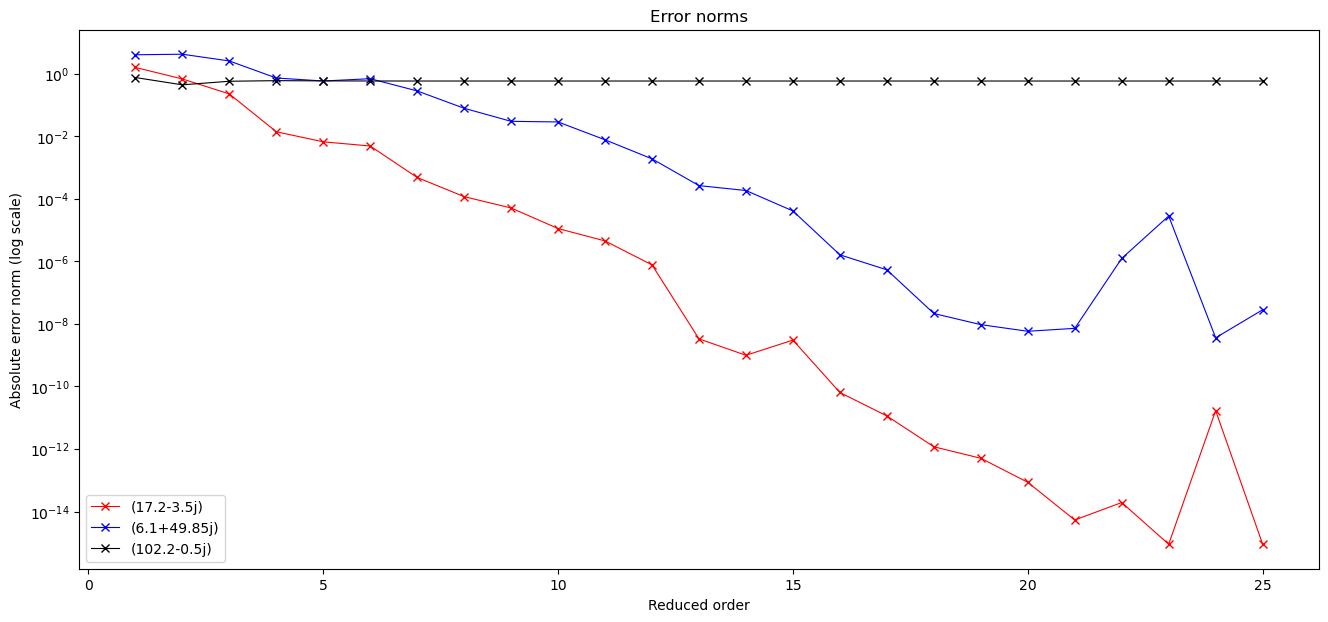

In [43]:
# Error norm plot
fig, ax = plt.subplots(figsize=(16, 7), dpi=100)
ax.semilogy(np.arange(1, range_plot + 1), error1, color='red', lw = 0.8, marker = 'x', label = s1)
ax.semilogy(np.arange(1, range_plot + 1), error2, color='blue', lw = 0.8, marker = 'x', label = s2)
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.set_ylabel("Absolute error norm (log scale)")
ax.legend()

# Show the plot
plt.show()